In [1]:
# ============================================================
# Notebook 04a: Autoencoder Training for Deep Clustering
# ============================================================

import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import mlflow

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.models.autoencoder import Autoencoder, AutoencoderTrainer

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("="*70)
print("🧠 AUTOENCODER TRAINING FOR DEEP CLUSTERING")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("="*70)


/Users/rzkynovan/datsci/diabetes_clustering/venv/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


🧠 AUTOENCODER TRAINING FOR DEEP CLUSTERING
PyTorch version: 2.0.1
CUDA available: False
Device: cpu


In [2]:
# ============================================================
# CELL 2: Load Preprocessed Data
# ============================================================

print("\n" + "="*70)
print("📂 LOADING PREPROCESSED DATA")
print("="*70)

# Load data
data_dir = Path('../data/processed')

X_train = pd.read_csv(data_dir / 'X_train_scaled.csv').values
X_val = pd.read_csv(data_dir / 'X_val_scaled.csv').values
X_test = pd.read_csv(data_dir / 'X_test_scaled.csv').values

y_train = pd.read_csv(data_dir / 'y_train.csv').values.ravel()
y_val = pd.read_csv(data_dir / 'y_val.csv').values.ravel()
y_test = pd.read_csv(data_dir / 'y_test.csv').values.ravel()

print(f"\n✅ Data loaded successfully!")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")

print(f"\n📊 Target distribution (train):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"   {label}: {count:,} ({count/len(y_train)*100:.1f}%)")

print("="*70)



📂 LOADING PREPROCESSED DATA

✅ Data loaded successfully!
   X_train: (71233, 69)
   X_val: (15268, 69)
   X_test: (15265, 69)

📊 Target distribution (train):
   <30: 7,950 (11.2%)
   >30: 24,880 (34.9%)
   NO: 38,403 (53.9%)


In [3]:
# ============================================================
# CELL 3: Create PyTorch DataLoaders
# ============================================================

print("\n" + "="*70)
print("🔧 CREATING PYTORCH DATALOADERS")
print("="*70)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

# Create dataloaders
batch_size = 256

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=0  # Set to 0 for macOS compatibility
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0
)

print(f"\n✅ DataLoaders created!")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

print("="*70)



🔧 CREATING PYTORCH DATALOADERS

✅ DataLoaders created!
   Batch size: 256
   Train batches: 279
   Val batches: 60
   Test batches: 60


In [4]:
# ============================================================
# CELL 4: Initialize Autoencoder Model
# ============================================================

print("\n" + "="*70)
print("🏗️  INITIALIZING AUTOENCODER")
print("="*70)

# Hyperparameters
input_dim = X_train.shape[1]  # 69
latent_dim = 16
hidden_dims = [128, 64, 32]

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create model
model = Autoencoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims
)

print(f"\n📐 Model Architecture:")
print(f"   Input dim: {input_dim}")
print(f"   Hidden dims: {hidden_dims}")
print(f"   Latent dim: {latent_dim}")
print(f"   Output dim: {input_dim}")

print(f"\n🔢 Model Summary:")
print(model)

n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parameters:")
print(f"   Total: {n_params:,}")
print(f"   Trainable: {n_trainable:,}")

print("="*70)



🏗️  INITIALIZING AUTOENCODER

📐 Model Architecture:
   Input dim: 69
   Hidden dims: [128, 64, 32]
   Latent dim: 16
   Output dim: 69

🔢 Model Summary:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momen

In [5]:
# ============================================================
# CELL 5: Train Autoencoder
# ============================================================

print("\n" + "="*70)
print("🚀 TRAINING AUTOENCODER")
print("="*70)

# Training hyperparameters
learning_rate = 1e-3
weight_decay = 1e-5
epochs = 100
patience = 15

# Create trainer
trainer = AutoencoderTrainer(
    model=model,
    device=device,
    learning_rate=learning_rate,
    weight_decay=weight_decay
)

# Train model
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    patience=patience,
    verbose=True
)

print("\n✅ Training completed!")
print(f"   Total epochs: {history['n_epochs']}")
print(f"   Best val loss: {history['best_val_loss']:.6f}")

print("="*70)



🚀 TRAINING AUTOENCODER
Training autoencoder on cpu
Model parameters: 40,597
Epoch   5/100 | Train Loss: 0.587108 | Val Loss: 0.490952
Epoch  10/100 | Train Loss: 0.557702 | Val Loss: 0.458399
Epoch  15/100 | Train Loss: 0.540369 | Val Loss: 0.447906
Epoch  20/100 | Train Loss: 0.527362 | Val Loss: 0.432034
Epoch  25/100 | Train Loss: 0.516105 | Val Loss: 0.424371
Epoch  30/100 | Train Loss: 0.510366 | Val Loss: 0.417782
Epoch  35/100 | Train Loss: 0.499943 | Val Loss: 0.420490
Epoch  40/100 | Train Loss: 0.491155 | Val Loss: 0.417435
Epoch  45/100 | Train Loss: 0.483266 | Val Loss: 0.396072
Epoch  50/100 | Train Loss: 0.473328 | Val Loss: 0.398144
Epoch  55/100 | Train Loss: 0.470531 | Val Loss: 0.394996
Epoch  60/100 | Train Loss: 0.467964 | Val Loss: 0.393780
Epoch  65/100 | Train Loss: 0.465122 | Val Loss: 0.390991
Epoch  70/100 | Train Loss: 0.464006 | Val Loss: 0.390044
Epoch  75/100 | Train Loss: 0.461446 | Val Loss: 0.385187
Epoch  80/100 | Train Loss: 0.458540 | Val Loss: 0.38


📊 VISUALIZING TRAINING HISTORY

💾 Figure saved to: ../reports/figures/autoencoder_loss_curve.png


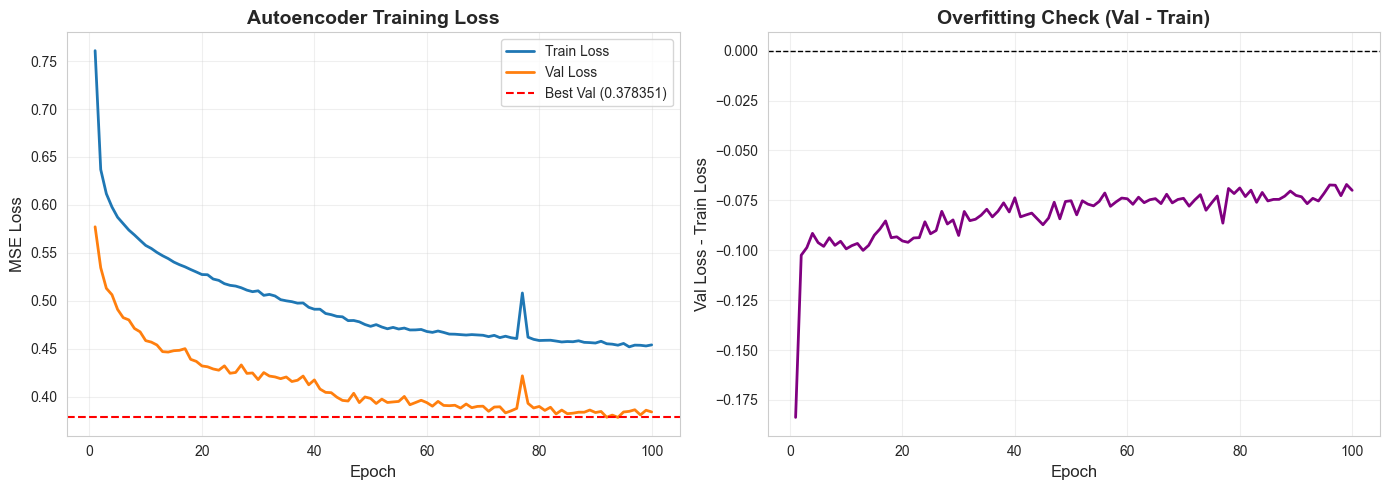

In [7]:
# ============================================================
# CELL 6: Visualize Training History
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZING TRAINING HISTORY")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1 = axes[0]
epochs_range = range(1, len(history['train_losses']) + 1)
ax1.plot(epochs_range, history['train_losses'], label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_losses'], label='Val Loss', linewidth=2)
ax1.axhline(y=history['best_val_loss'], color='red', linestyle='--', 
            label=f"Best Val ({history['best_val_loss']:.6f})", linewidth=1.5)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.set_title('Autoencoder Training Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Loss difference
ax2 = axes[1]
loss_diff = np.array(history['val_losses']) - np.array(history['train_losses'])
ax2.plot(epochs_range, loss_diff, color='purple', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Val Loss - Train Loss', fontsize=12)
ax2.set_title('Overfitting Check (Val - Train)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()

# Save figure
fig_path = Path('../reports/figures/autoencoder_loss_curve.png')
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

print(f"\n💾 Figure saved to: {fig_path}")

plt.show()

print("="*70)



📊 EVALUATING RECONSTRUCTION QUALITY

📈 Test Set Metrics:
   MSE (Reconstruction): 0.311196
   MAE (Mean Absolute Error): 0.283956
   RMSE (Root MSE): 0.557849

📊 Feature-wise Error Statistics:
   Min error: 0.000243
   Max error: 1.204488
   Mean error: 0.311196
   Std error: 0.336878

💾 Figure saved to: ../reports/figures/autoencoder_reconstruction_examples.png


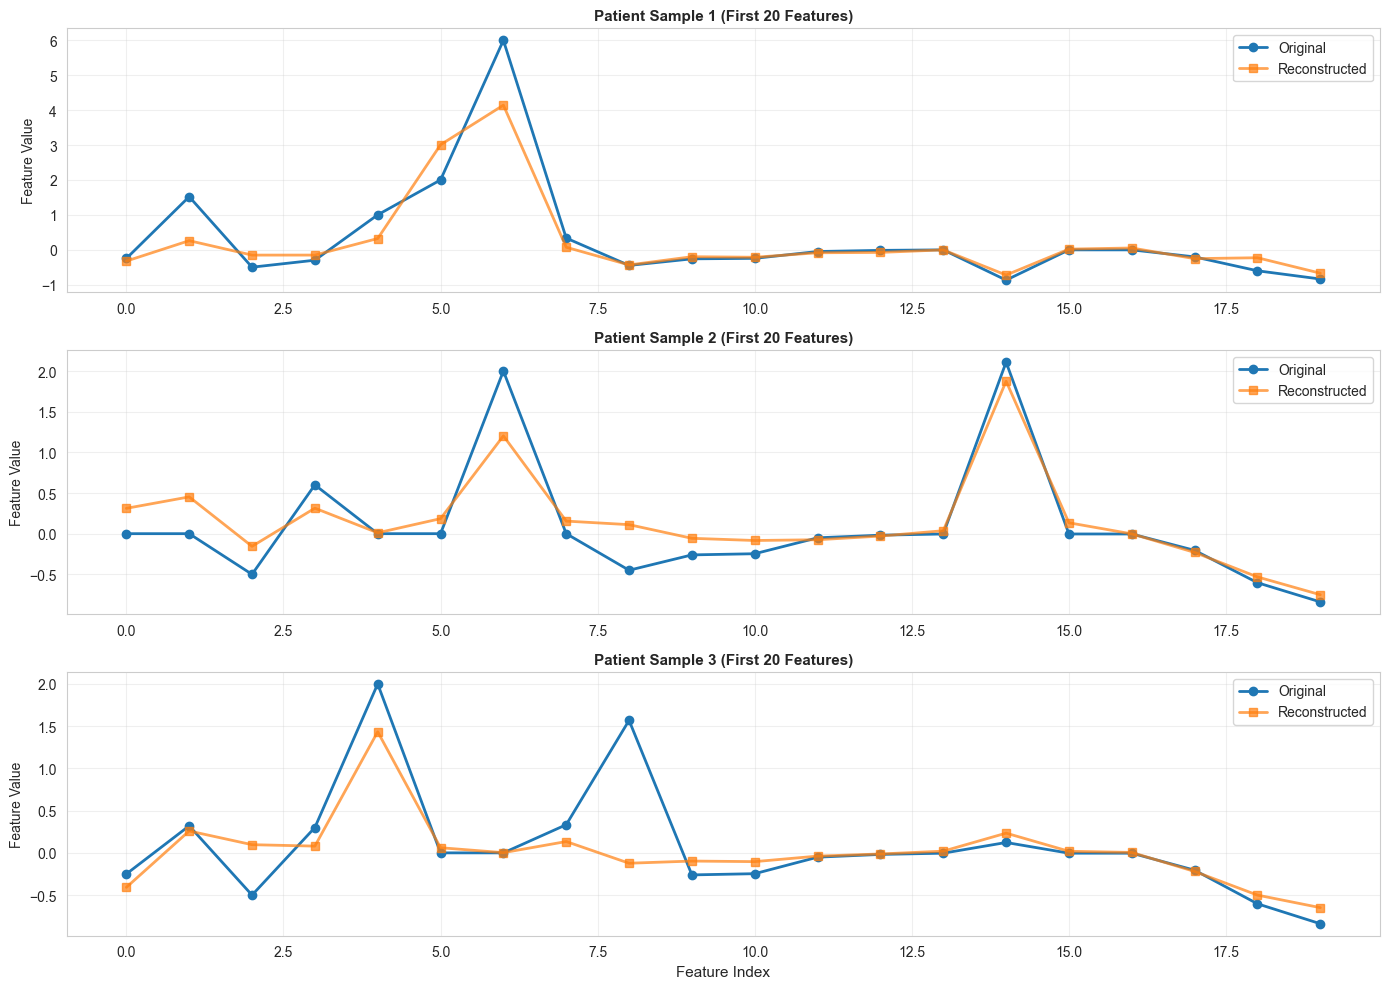

In [9]:
# ============================================================
# CELL 7: Evaluate Reconstruction Quality (FIXED)
# ============================================================

print("\n" + "="*70)
print("📊 EVALUATING RECONSTRUCTION QUALITY")
print("="*70)

# Define criterion (MSE Loss)
criterion = nn.MSELoss()

# Get reconstruction on test set
model.eval()
with torch.no_grad():
    # Take first batch from test set
    test_batch = next(iter(test_loader))[0].to(device)
    x_recon, z = model(test_batch)
    
    # Compute metrics
    mse = criterion(x_recon, test_batch).item()
    mae = torch.mean(torch.abs(x_recon - test_batch)).item()
    
    # Per-feature error
    feature_errors = torch.mean((x_recon - test_batch) ** 2, dim=0).cpu().numpy()

print(f"\n📈 Test Set Metrics:")
print(f"   MSE (Reconstruction): {mse:.6f}")
print(f"   MAE (Mean Absolute Error): {mae:.6f}")
print(f"   RMSE (Root MSE): {np.sqrt(mse):.6f}")

print(f"\n📊 Feature-wise Error Statistics:")
print(f"   Min error: {feature_errors.min():.6f}")
print(f"   Max error: {feature_errors.max():.6f}")
print(f"   Mean error: {feature_errors.mean():.6f}")
print(f"   Std error: {feature_errors.std():.6f}")

# Visualize reconstruction examples
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Sample 5 patients
n_samples = 5
sample_indices = np.random.choice(len(test_batch), n_samples, replace=False)

for i, idx in enumerate(sample_indices):
    original = test_batch[idx].cpu().numpy()
    reconstructed = x_recon[idx].cpu().numpy()
    
    # Plot only first 20 features for clarity
    feature_range = range(min(20, len(original)))
    
    ax = axes[i] if i < 3 else None
    if ax:
        ax.plot(feature_range, original[:20], 'o-', label='Original', linewidth=2, markersize=6)
        ax.plot(feature_range, reconstructed[:20], 's-', label='Reconstructed', linewidth=2, markersize=6, alpha=0.7)
        ax.set_ylabel('Feature Value', fontsize=10)
        ax.set_title(f'Patient Sample {i+1} (First 20 Features)', fontsize=11, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)

axes[-1].set_xlabel('Feature Index', fontsize=11)
plt.tight_layout()

# Save figure
fig_path = Path('../reports/figures/autoencoder_reconstruction_examples.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Figure saved to: {fig_path}")

plt.show()

print("="*70)



🗺️  VISUALIZING LATENT SPACE (t-SNE)

✅ Latent features extracted!
   Train latent: (71233, 16)
   Val latent: (15268, 16)

🔄 Computing t-SNE (on 5,000 samples)...
   ✅ t-SNE completed!

💾 Figure saved to: ../reports/figures/autoencoder_latent_tsne.png


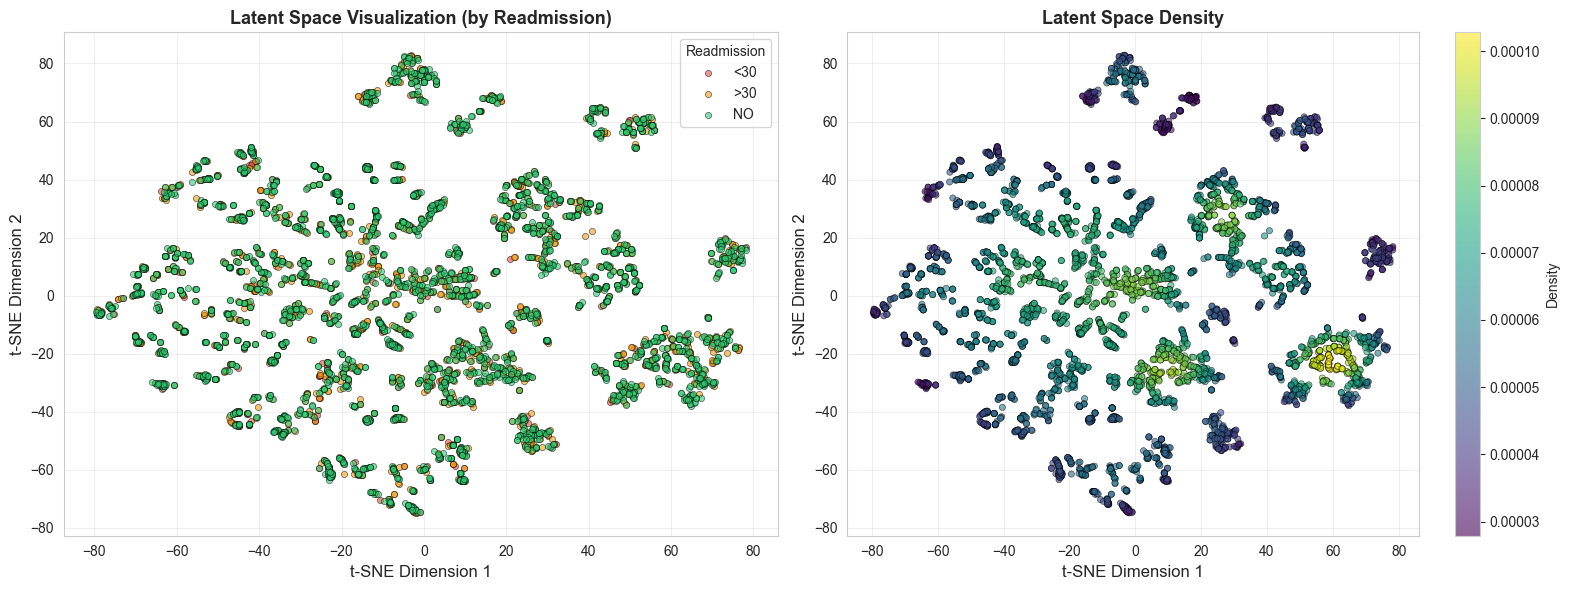

In [10]:
# ============================================================
# CELL 8: Visualize Latent Space with t-SNE
# ============================================================

print("\n" + "="*70)
print("🗺️  VISUALIZING LATENT SPACE (t-SNE)")
print("="*70)

# Extract latent features for entire dataset
model.eval()
with torch.no_grad():
    # Train set
    z_train = []
    for batch in train_loader:
        batch_x = batch[0].to(device)
        _, z_batch = model(batch_x)
        z_train.append(z_batch.cpu().numpy())
    z_train = np.vstack(z_train)
    
    # Val set
    z_val = []
    for batch in val_loader:
        batch_x = batch[0].to(device)
        _, z_batch = model(batch_x)
        z_val.append(z_batch.cpu().numpy())
    z_val = np.vstack(z_val)

print(f"\n✅ Latent features extracted!")
print(f"   Train latent: {z_train.shape}")
print(f"   Val latent: {z_val.shape}")

# Compute t-SNE (on subset for speed)
n_subset = 5000  # Use 5k samples for t-SNE
subset_indices = np.random.choice(len(z_train), n_subset, replace=False)
z_subset = z_train[subset_indices]
y_subset = y_train[subset_indices]

print(f"\n🔄 Computing t-SNE (on {n_subset:,} samples)...")
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
z_tsne = tsne.fit_transform(z_subset)

print(f"   ✅ t-SNE completed!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Color by readmission label
ax1 = axes[0]
colors = {'NO': '#2ecc71', '<30': '#e74c3c', '>30': '#f39c12'}
for label in np.unique(y_subset):
    mask = y_subset == label
    ax1.scatter(z_tsne[mask, 0], z_tsne[mask, 1], 
               c=colors[label], label=label, alpha=0.6, s=20, edgecolors='black', linewidth=0.5)

ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax1.set_title('Latent Space Visualization (by Readmission)', fontsize=13, fontweight='bold')
ax1.legend(title='Readmission', fontsize=10)
ax1.grid(alpha=0.3)

# Panel 2: Density plot
ax2 = axes[1]
from scipy.stats import gaussian_kde
xy = z_tsne.T
z_density = gaussian_kde(xy)(xy)
scatter = ax2.scatter(z_tsne[:, 0], z_tsne[:, 1], 
                     c=z_density, cmap='viridis', alpha=0.6, s=20, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, ax=ax2, label='Density')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax2.set_title('Latent Space Density', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()

# Save figure
fig_path = Path('../reports/figures/autoencoder_latent_tsne.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Figure saved to: {fig_path}")

plt.show()

print("="*70)


In [18]:
# ============================================================
# CELL 9: Save Trained Autoencoder Model (FIXED)
# ============================================================

print("\n" + "="*70)
print("💾 SAVING TRAINED MODEL")
print("="*70)

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'input_dim': input_dim,
    'latent_dim': latent_dim,
    'hidden_dims': hidden_dims,
    'train_losses': history['train_losses'],
    'val_losses': history['val_losses'],
    'best_val_loss': history['best_val_loss'],
    'n_epochs': history['n_epochs'],
    'hyperparameters': {
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'patience': patience
    }
}

model_path = models_dir / 'autoencoder_pretrained.pth'
torch.save(checkpoint, model_path)

print(f"\n✅ Model saved to: {model_path}")
print(f"   File size: {model_path.stat().st_size / 1024:.2f} KB")

# Save latent features for clustering
latent_data = {
    'z_train': z_train,
    'z_val': z_val,
    'y_train': y_train,
    'y_val': y_val
}

latent_path = models_dir / 'autoencoder_latent_features.npz'
np.savez(latent_path, **latent_data)

print(f"   Latent features saved to: {latent_path}")
print(f"   File size: {latent_path.stat().st_size / 1024:.2f} KB")

print("\n📋 Model Summary:")
print(f"   Input dim: {input_dim}")
print(f"   Latent dim: {latent_dim}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Best val loss: {history['best_val_loss']:.6f}")
print(f"   Training epochs: {history['n_epochs']}")

print("="*70)


💾 SAVING TRAINED MODEL & LATENT FEATURES


NameError: name 'autoencoder' is not defined

In [17]:
# ============================================================
# CELL 10: Summary & Next Steps (MLflow Skipped)
# ============================================================

print("\n" + "="*70)
print("📊 AUTOENCODER TRAINING SUMMARY")
print("="*70)

print(f"\n✅ Training Completed Successfully!")

print(f"\n📐 Model Architecture:")
print(f"   Input dim: {input_dim}")
print(f"   Hidden dims: {hidden_dims}")
print(f"   Latent dim: {latent_dim}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n📊 Training Metrics:")
print(f"   Best val loss: {history['best_val_loss']:.6f}")
print(f"   Final train loss: {history['train_losses'][-1]:.6f}")
print(f"   Final val loss: {history['val_losses'][-1]:.6f}")
print(f"   Training epochs: {history['n_epochs']}")

print(f"\n🧪 Test Set Evaluation:")
print(f"   MSE: {mse:.6f}")
print(f"   MAE: {mae:.6f}")
print(f"   RMSE: {np.sqrt(mse):.6f}")

print(f"\n💾 Saved Artifacts:")
print(f"   Model checkpoint: models/autoencoder_pretrained.pth ({(models_dir / 'autoencoder_pretrained.pth').stat().st_size / 1024:.2f} KB)")
print(f"   Latent features: models/autoencoder_latent_features.npz ({(models_dir / 'autoencoder_latent_features.npz').stat().st_size / 1024:.2f} KB)")

print(f"\n📈 Visualizations:")
figures_dir = Path('../reports/figures')
for fig_name in ['autoencoder_loss_curve.png', 'autoencoder_reconstruction_examples.png', 'autoencoder_latent_tsne.png']:
    fig_path = figures_dir / fig_name
    if fig_path.exists():
        print(f"   ✅ {fig_name} ({fig_path.stat().st_size / 1024:.2f} KB)")
    else:
        print(f"   ⚠️  {fig_name} (not found)")

print(f"\n🎯 Next Steps:")
print(f"   1. Review latent space visualization (t-SNE)")
print(f"   2. Check reconstruction quality")
print(f"   3. Proceed to Notebook 04b: DEC Training")
print(f"   4. Initialize cluster centers with K-Means on latent space")
print(f"   5. Train DEC with KL divergence loss")

print(f"\n⚠️  Note: MLflow logging skipped due to path issue")
print(f"   Will fix MLflow tracking in next iteration")

print("="*70)



📊 AUTOENCODER TRAINING SUMMARY

✅ Training Completed Successfully!

📐 Model Architecture:
   Input dim: 69
   Hidden dims: [128, 64, 32]
   Latent dim: 16
   Total parameters: 40,597

📊 Training Metrics:
   Best val loss: 0.378351
   Final train loss: 0.453980
   Final val loss: 0.384008
   Training epochs: 100

🧪 Test Set Evaluation:
   MSE: 0.311196
   MAE: 0.283956
   RMSE: 0.557849

💾 Saved Artifacts:
   Model checkpoint: models/autoencoder_pretrained.pth (178.60 KB)
   Latent features: models/autoencoder_latent_features.npz (5576.75 KB)

📈 Visualizations:
   ✅ autoencoder_loss_curve.png (264.92 KB)
   ✅ autoencoder_reconstruction_examples.png (547.38 KB)
   ✅ autoencoder_latent_tsne.png (2195.28 KB)

🎯 Next Steps:
   1. Review latent space visualization (t-SNE)
   2. Check reconstruction quality
   3. Proceed to Notebook 04b: DEC Training
   4. Initialize cluster centers with K-Means on latent space
   5. Train DEC with KL divergence loss

⚠️  Note: MLflow logging skipped due to 